# Bayes Net Model

## Overview

Given the bikes that have departed so far today, how many bikes will be available at all stations in the next 30 minutes? 

For the sake of our analysis, we will work with trips data only (avialable bikes being calculated as deltas of real data deltas, and not from status, as it is presently unclear how much bike redistribution takes place in the current data). 

The general structure of the model is to use as priors the conditional probabilities of all stations as root nodes sending bikes to all nonroot nodes (by month, day-type, weather, and five minute time increment). These means that all stations are treated as nodes, yet since arrivals do not influence the probability of the next conditional probability mapping in the next 5 minutes, we can think of the destination bins as an indpendent calculation from the network. We will start with new priors each 5 minutes. 

My thought for the "typical_day_index" is to create a weighted factor that is calculated from each station's activity up to the bin we are starting our prediction at. If the day is "slow", we will attenuate our predictions. If there is high volume, we will boost our predictions. This will be a scaler weight that is the ratio of the diference between the current day and historical average of bikes deployed divided by the 

x = b_current_total - b_historical_total

weighted_probability = conditional_probability * (1 + x) 

## Primary features

For each non-root node we will calculate: 
* start_avail_bikes
* avail_bikes_delta ** This is what our model is estimating**
* end_avail_bikes  = y_start_avail_bikes + y_avail_bikes_delta

## Features used to calculate available bikes delta

* start_station
* time_bin
* day_type
* weather
* month 
* typical_index

## Quanifying states and changes

A simple way to think about states in this model is to visualize a plot of all the binned departures and arrivals for each station by some time interval. Let's say every five minutes in the hour preceeding our start time. Minute by minute we cast a distribution for our station feeding all other stations in the network in the future based on the prior of our current available bike deltas for that day (not absolute bikes available, as redistribution might change from day to day). 

I imagine this as a series of snapshots (matrices) for each station showing the departure times of bikes that fed into that station over the course of the day so far. Given the patterns we see in those changing states today, what examplar day in our station's hisotry does that most resemble? What are our predictive results if we adopt that day's regression model for each feeder station?

In this case, the regressions for our model are selected station by station for all of our possible 83 feeder stations, based on their activity that day (leading us to the most similar branch). 

## Load May data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pprint
%load_ext autoreload
from pylab import rcParams
from pymc3 import  *

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [2]:
may_15 = pd.read_csv('~/Code/bikesupply/data/test_data/trips_may2015.csv', parse_dates = ['start_date'])
may_16 = pd.read_csv('~/Code/bikesupply/data/test_data/trips_may2016.csv', parse_dates = ['start_date'])

In [3]:
may_15 = may_15.set_index('start_date')
may_15['weekday'] = [ts.weekday() for ts in may_15.index]
may_15['start_hour'] = [ts.hour for ts in may_15.index]
may_15['start_minutes'] = [ts.minute for ts in may_15.index]
may_15['start_time_in_mins'] = (may_15['start_day'] * 1440) + (may_15['start_hour'] * 60) + may_15['start_minutes']

In [4]:
may_15 = may_15.reset_index()

In [5]:
may_15['end_date'] = pd.to_datetime(may_15['end_date'])

In [6]:
may_15 = may_15.set_index('end_date')
may_15['end_hour'] = [ts.hour for ts in may_15.index]
may_15['end_minutes'] = [ts.minute for ts in may_15.index]
may_15['end_time_in_mins'] = (may_15['end_day'] * 1440) + (may_15['end_hour'] * 60) + may_15['end_minutes']

In [7]:
may_15 = may_15.reset_index()

## Trip lengths

In [8]:
may_15['deltas'] = may_15['end_time_in_mins'] - may_15['start_time_in_mins']

In [9]:
deltas = may_15['deltas']
deltas = pd.Series(deltas).where(lambda x : x >= 0).dropna()

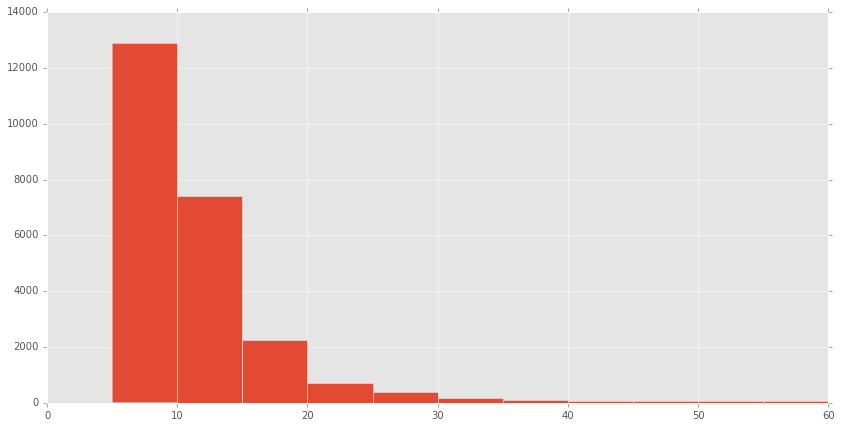

In [10]:
rcParams['figure.figsize'] =  14, 7

deltas.hist(bins = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

In [11]:
deltas_15

NameError: name 'deltas_15' is not defined

In [ ]:
# Create bins of +60 minute intervals for each station and populate with arrival data (for training)

## May 4, 2015

As we have for our other models, let's bild for a particular day. Let's select May 4, 2015 (the first Monday in May). 

In [13]:
# Filter May 4 data
may_4 = may_15.query('start_day == 4')

# Calculate bike deltas for that day from trips (not from status)
# Zero into a busy time of day - calculate the delta from ten-minutes before start to start, 
# and calculate deltas for each station in the next 30 minutes

In [17]:
thirty_minutes = may_4.query('start_time_in_mins >=6480 and start_time_in_mins <= 6510')

In [20]:
thirty_minutes[0:5]

,end_date,start_date,Unnamed: 0,trip_id,duration_sec,start_station_name,start_station_id,end_station_name,end_station_id,bike_number,...,end_time,end_yyyymmdd,weekday,start_hour,start_minutes,start_time_in_mins,end_hour,end_minutes,end_time_in_mins,deltas
539,2015-05-04 12:27:00,2015-05-04 12:12:00,16767,751935,875,Beale at Market,56,2nd at South Park,64,158,...,12:27:00,20150504,0,12,12,6492,12,27,6507,15
1679,2015-05-04 12:07:00,2015-05-04 12:03:00,54942,751930,199,Embarcadero at Vallejo,48,Steuart at Market,74,442,...,12:07:00,20150504,0,12,3,6483,12,7,6487,4
1788,2015-05-04 12:09:00,2015-05-04 12:04:00,58772,751931,287,San Pedro Square,6,San Jose Diridon Caltrain Station,2,103,...,12:09:00,20150504,0,12,4,6484,12,9,6489,5
2972,2015-05-04 12:22:00,2015-05-04 12:11:00,97959,751932,683,Civic Center BART (7th at Market),72,2nd at Folsom,62,607,...,12:22:00,20150504,0,12,11,6491,12,22,6502,11
4478,2015-05-04 12:26:00,2015-05-04 12:16:00,148699,751941,569,Washington at Kearny,46,Post at Kearny,47,300,...,12:26:00,20150504,0,12,16,6496,12,26,6506,10


In [21]:
# https://plot.ly/ipython-notebooks/network-graphs/

##  Average travel time between stations

This will be used to predict when to "bin" the predicted arriving bikes at the target station.

## PyMC3

In [ ]:
from scipy.stats import norm
from pymc import Normal, Lambda, Bernoulli
from numpy import mean, std

# Data
grade = (0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1)
sat = (525, 533, 545, 582, 581, 576, 572, 609, 559, 543, 576, 525, 574, 582, 574, 471, 595, 557, 557, 584, 599, 517, 649, 584, 463, 591, 488, 563, 553, 549)

# Probit transform
probit = norm.cdf

# Linear model parameters
alpha = Normal('alpha', mu=0.0, tau=0.001, value=0)
beta = Normal('beta', mu=0.0, tau=0.001, value=0)

# Probability of passing
p = Lambda('p', lambda a=alpha, b=beta, x=sat: probit(a+b*x))

# Data likelihood
y = Bernoulli('y', p=p, value=grade, observed=True)

if __name__ == '__main__':
    
    from pymc import MCMC, Matplot
    M = MCMC([alpha, beta, p, y])
    M.isample(20000, 10000, verbose=2)
    Matplot.plot(M)

 PyMC console

        PyMC is now sampling. Use the following commands to query or pause the sampler.
        

        Commands:
          i -- index: print current iteration index
          p -- pause: interrupt sampling and return to the main console.
                      Sampling can be resumed later with icontinue().
          h -- halt:  stop sampling and truncate trace. Sampling cannot be
                      resumed for this chain.
          b -- bg:    return to the main console. The sampling will still
                      run in a background thread. There is a possibility of
                      malfunction if you interfere with the Sampler's
                      state or the database during sampling. Use this at your
                      own risk.
        
pymc > 	Tuning at iteration 1000
	Metropolis_beta tuning:
		value: 0.00147251777466
		acceptance rate: 0.001
		adaptive scale factor: 0.5



In [70]:
# Testing out code from https://healthyalgorithms.com/2011/11/23/causal-modeling-in-python-bayesian-networks-in-pymc/
# sprinkler.py
import pylab as pl
import pymc as mc
 
G_obs = [1.]
N = len(G_obs)
 
R = mc.Bernoulli('R', .2, value=pl.ones(N))
 
p_S = mc.Lambda('p_S', lambda R=R: pl.where(R, .01, .4),
                doc='Pr[S|R]')
S = mc.Bernoulli('S', p_S, value=pl.ones(N))
 
p_G = mc.Lambda('p_G', lambda S=S, R=R:
                pl.where(S, pl.where(R, .99, .9), pl.where(R, .8, 0.)),
                doc='Pr[G|S,R]')
G = mc.Bernoulli('G', p_G, value=G_obs, observed=True)

In [71]:
import sprinkler
m = mc.MCMC(sprinkler)
m.sample(100000)

ImportError: No module named sprinkler

# Muli-layer Perceptron Regressor

http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor



## Validation

Coming soon!